# Fitting pipeline using pylorenzmie

In order to fit an hologram, I used the pylorenzmie model which provides a set of python classes in order to analyse holographic microscopy data.

Pylorenzmie can be download on the David Grier's github repository: https://github.com/davidgrier/pylorenzmie.

What I actually get from the experiments are mp4 movies, in order to analyze them easily, I constructed a wrapper around the pylorenzmie module which can be found on my repository: https://github.com/eXpensia/wraplorenzmie.

This wrapper permits to do the following pipeline:

- Directly load the movies
- Compute the back ground.
- Use the first image in order to get the pre guesses
- Fit the 10 000 first images to determine precisely the radius and index of a particle.
- Use the later information in order to fit the whole movie (and save the data in the same time)

One that done, the trajectory be analyzed separately. 







In [1]:
# We first start by import the important modules

import wraplorenzmie.utilities.utilities as utilities
import wraplorenzmie.fits.fit as fit
import imageio
# For Plotting.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
#sns.set(style='white', font_scale=2)
%matplotlib inline
import matplotlib as mpl


mpl.rcParams["figure.dpi"] = 200
from matplotlib import rc
rc('font', family='serif')
rc('text', usetex=True)
rc('xtick', labelsize='x-small')
rc('ytick', labelsize='x-small')

def cm2inch(value):
    return value/2.54

No module named 'pylorenzmie.fitting.cython.cminimizers'


In [2]:
#We load the movie
vid = utilities.video_reader("Basler_acA1920-155um__22392621__20200527_162231224.mp4")

In [3]:
# A function that permits to compute de radial profile of an image this will later be used in order to see if the fits are done correctly
def radial_profile(data, center=None):
    if center==None:
        center = np.array(np.shape(data)) / 2
    
    y, x = np.indices((data.shape))
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    r = r.astype(int)

    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / nr
    
    T = data.ravel()
    V = r.ravel()
    
    err = [np.std(T[V == u]) for u in np.unique(V)]
    
    return radialprofile, err



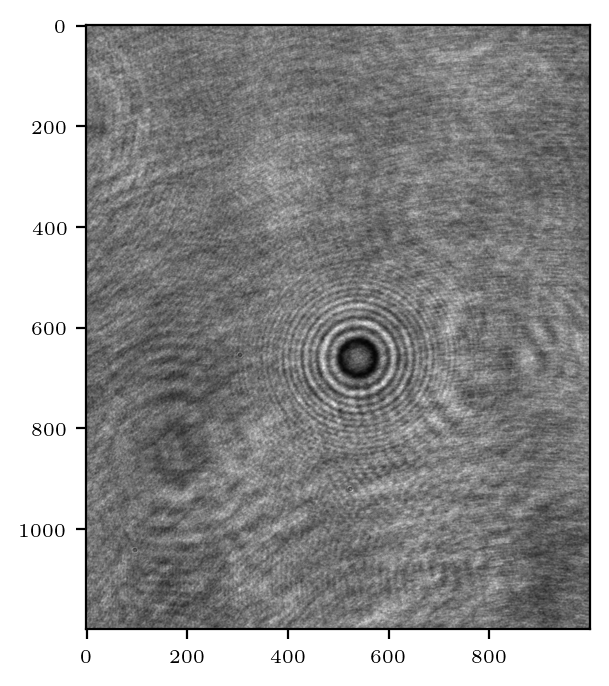

In [4]:
# We take a look at the first image of the movie
image = vid.get_image(1)
plt.imshow(image,cmap="gray")

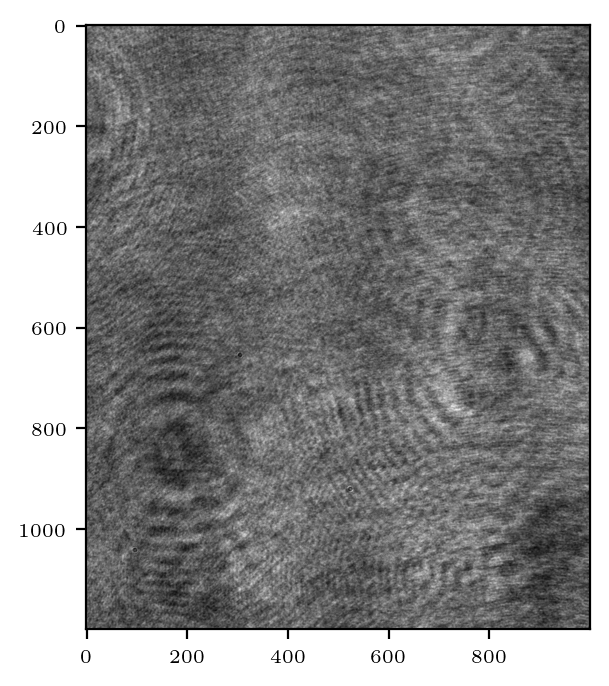

In [5]:
# set the background image (it can also be computed using vid.get_background method)
vid.number = 125000
vid.background = np.array(imageio.imread("background.tiff"))
#vid.background = vid.get_background(n=50) # n is the number of image to use to compute the background
plt.imshow(vid.background,cmap="gray")

In [6]:
imageio.imwrite("background.tiff",vid.background)# We save the background for possible later use.

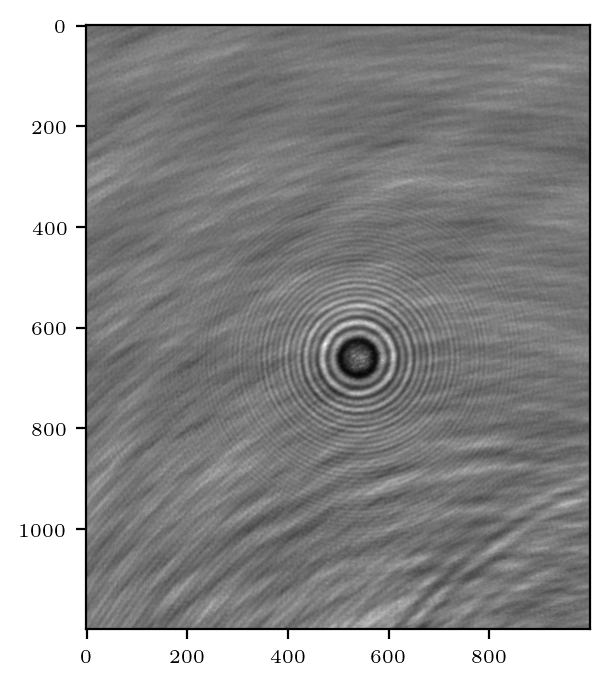

In [7]:
# the normalized image, we can see that their is some movement in the background.
# This could be avoided by computed the background as a function of the time, if the particle diffuses enough.
normed_image = utilities.normalize(image,vid.background)
plt.imshow(normed_image,cmap="gray")
normed_image = normed_image

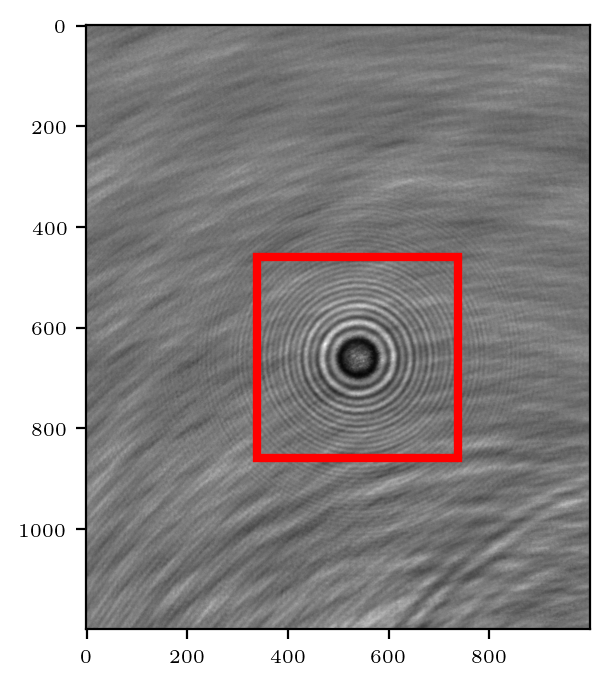

In [8]:
# We found the possition of the particle
feature = utilities.center_find(image)[0]
utilities.plot_bounding(normed_image,feature)

## Fitting the first image

We fit the first image in order to get the preguess.
We first start by croping the hologram.

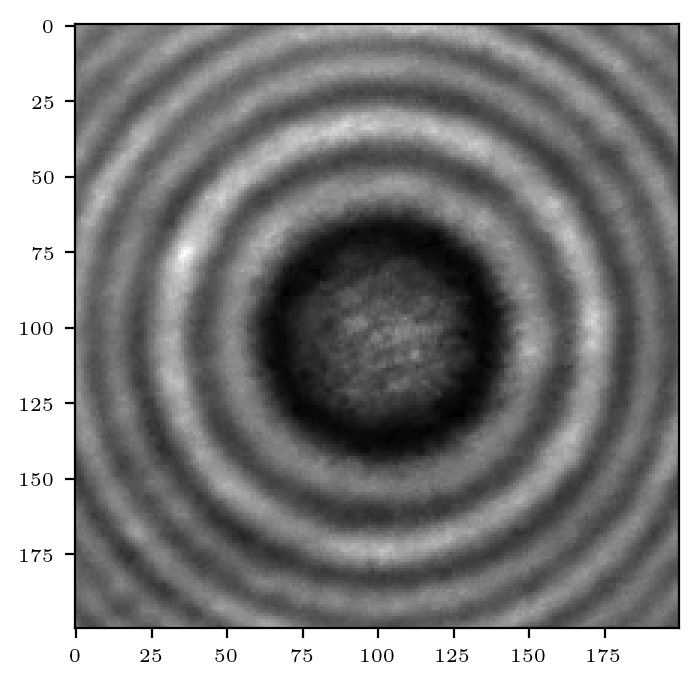

In [89]:
xc, yc, w, h = feature[0]
x_center = xc
y_center = yc
h=200
im_c = fit.crop(image, int(xc), int(yc), int(h))
bk_c = fit.crop(vid.background, int(xc), int(yc), int(h))
cropped = utilities.normalize(im_c,bk_c, dark_count = np.min(im_c))
cropped = cropped / np.mean(cropped)
plt.imshow(cropped,cmap = "gray")


In [10]:
# We setup the fitting method.
fitter = fit.fitting(cropped,0.532,0.0513)
fitter.make_guess(1.50,1.59,12,alpha = 1,fit_r=True, fit_n=True,fit_alpha=True)

In [11]:
# We do the actual fit.
result = fitter.fit_single(cropped, method = "lm")

In [12]:
zo = result.result["x"][2]*0.0513
print(result.result["x"][2]*0.0513)
print(result.redchi)
print(result.result["x"])

11.427616273713154
7.2459765196825305
[101.23514587 103.00299474 222.76055114   1.5310255    1.58239091
   1.00198476]


We can plot the result to see if the fit worked properly, and, for a more quantitative comparison we can compute the radial intensity profile of both hologram and compare them.

In [13]:
center = np.array(np.shape(fitter.image))

In [14]:
radial_exp, err = radial_profile(fitter.image)
theo_exp, err = radial_profile(fitter.fitter.model.hologram().reshape(fitter.shape))
# computing first the holgram using the fit resutlt


<Figure size 3000x3000 with 0 Axes>

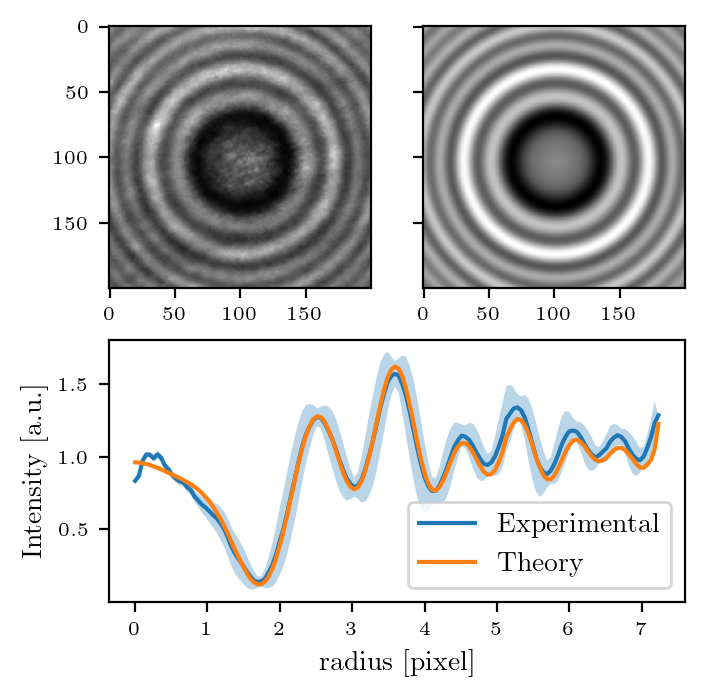

In [15]:

fit_data = {}
radius_radial = np.arange(len(radial_exp)) * 0.0513
plt.figure(figsize = (15,15))
fig = plt.figure(figsize=(cm2inch(8.6),1.65*cm2inch(8.6)))
fig.subplots_adjust(left=0.14, bottom=.12, right=.99, top=.98)

plt.subplot(2,2,1)
plt.imshow(fitter.image, cmap = "gray")
#plt.title('subplot(2,2,1)')

fit_data["exp_image"] = fitter.image

plt.subplot(2,2,2)
plt.imshow(fitter.fitter.model.hologram().reshape(fitter.shape), cmap = "gray")
frame1 = plt.gca()
frame1.axes.yaxis.set_ticklabels([])

fit_data["th_image"] = fitter.fitter.model.hologram().reshape(fitter.shape)


#plt.title('subplot(2,2,2)')

plt.subplot(2,2,(3,4))
plt.plot(radius_radial, radial_exp, label="Experimental")
plt.fill_between(radius_radial, radial_exp - err, radial_exp + err, alpha = 0.3)
plt.plot(radius_radial, theo_exp, label="Theory")
plt.legend()
plt.xlabel("radius [pixel]")
plt.ylabel("Intensity [a.u.]")

fit_data["I_r_exp"] = radial_exp
fit_data["I_errr_exp"] = err

fit_data["theo_exp"] = theo_exp
fit_data["I_radius"] = radius_radial

fig.set_size_inches(cm2inch(8.6), cm2inch(1.6 * 8.6/1.618))
plt.savefig("fit_fig.pdf")

In [16]:
fitter.fit_video(vid = vid,savefile="find_nrfit_result_dur_27052020_n_r_fix_0p0513_wav532.dat",xc = x ,yc= y, h = 200, n_end=10000,method = "lm")

100%|██████████████████████████████████████████████████████████████████████████████| 9999/9999 [12:39<00:00, 13.17it/s]


In [77]:
# Since the measurement or not saved into the ram we need to load it
n_r = np.fromfile('find_nr_exame.dat', dtype=np.float64)
n_r = n_r.reshape(len(n_r)//10,10)
r = n_r[:,3]
n = n_r[:,4]

## Fitting the n, r distributiton using a KDE estimator

To find the most probable couple of r/n we use a kde estimator using `seaborn`




In [81]:
import numpy as np
import scipy.stats as st
import matplotlib.ticker as ticker

data = np.random.multivariate_normal((0, 0), [[0.8, 0.05], [0.05, 0.7]], 100)
x = r[(r>1.5) & (r<1.555)]
y = n[(r>1.5) & (r<1.555)]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)

# Peform the kernel density estimate
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = st.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)
f = f/np.max(f)


In [82]:
np.round(np.max(f))

1.0

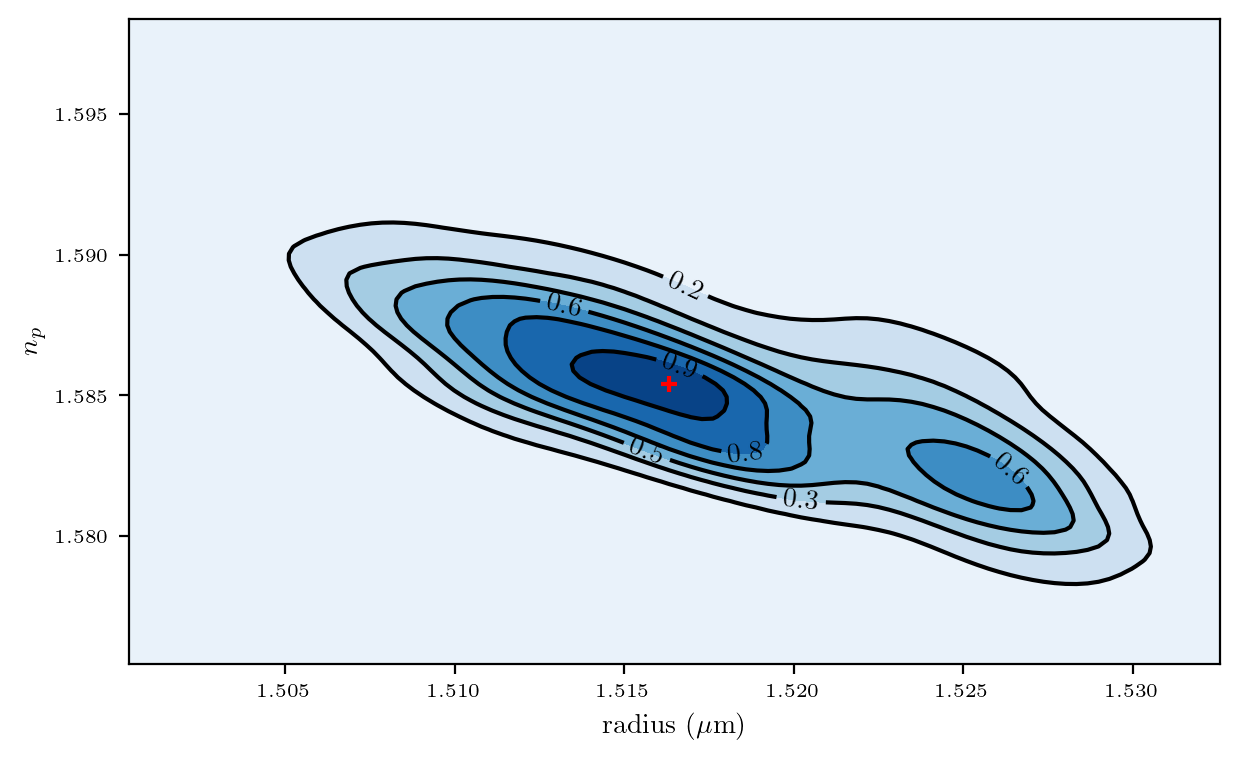

In [83]:
fig = plt.figure()
fig.subplots_adjust(left=0.16, bottom=.20, right=.99, top=.99)
ax = fig.gca()
#ax.set_xlim(1.505, 1.53)
#ax.set_ylim(1.575, 1.6)
# Contourf plot
cfset = ax.contourf(xx, yy, f, cmap='Blues')
## Or kernel density estimate plot instead of the contourf plot
#ax.imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
# Contour plot
cset = ax.contour(xx, yy, f, colors='k', levels=6)
# Label plot
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%1.3f'))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%1.3f'))
ax.clabel(cset, inline=1, fontsize=10, fmt="%1.1f")
plt.scatter(xx[np.where(f == 1)],yy[np.where(f == 1)], color = "red", marker="+")
ax.set_xlabel("radius ($\mathrm{\mu m}$)")
ax.set_ylabel("$n_p$")
#plt.title("KDE r n")
fig.set_size_inches(cm2inch(16), cm2inch(9.9))

plt.tight_layout()
fig.savefig('KDErn.pdf')
#pl.show()

In [84]:
print(" n determined with : mu={0}, sigma={1}".format(np.mean(yy[np.where(f > 0.1)]), np.std(yy[np.where(f > 0.1)])))
print(" r determined with : mu={0}, sigma={1}".format(np.mean(xx[np.where(f > 0.1)]), np.std(xx[np.where(f > 0.1)])))


 n determined with : mu=1.5851200393768743, sigma=0.003267685282504072
 r determined with : mu=1.5181266656310368, sigma=0.00682411690457934


In [85]:
(mu_n, mu_r) = np.mean(yy[np.where(f > 0.1)]) ,  np.mean(xx[np.where(f > 0.1)])

## Fitting the whole movie

Now that the measurement of n and r is one we can move on the measurement of the whole trajectory by simply using `fitter.fit_video`. For demonstration purposes, I only fit here at $\simeq 22$ image per seconds, if can goes up to at least $60$ with recent GPU.

In [93]:
del fitter
fitter = fit.fitting(cropped,0.532,0.0513)
fitter.make_guess(mu_r,mu_n,zo,alpha = 1,fit_r=False, fit_n=False,fit_alpha=False)
#result = fitter.fit_single(cropped, method = "lm")
fitter.fit_video(vid = vid,savefile="fit_result_1p5kPa_18122019_n_r_fix_0p0883_wav_532_ex1.dat",xc = xc ,yc= yc, h = 200, n_end=10000,method = "lm")

100%|██████████████████████████████████████████████████████████████████████████████| 9999/9999 [07:24<00:00, 22.47it/s]


In [94]:
import numpy as np
data = np.fromfile('fit_result_1p5kPa_18122019_n_r_fix_0p0883_wav_532_ex1.dat', dtype=np.float64)
data = data.reshape(len(data)//10,10)
x = data[:,0]*0.0513
y = data[:,1]*0.0513
z = data[:,2]*0.0513

## Plot the trajectory

Text(0.5, 0, 'time (s)')

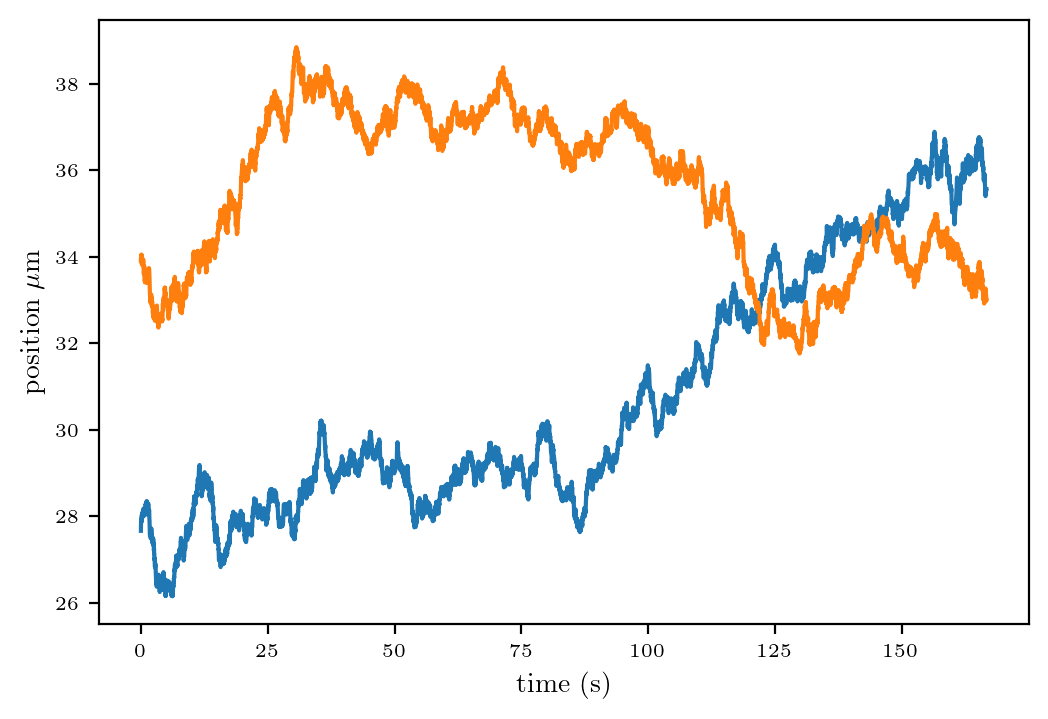

In [98]:
plt.plot(np.arange(len(z))/60, x)
plt.plot(np.arange(len(z))/60, y)
plt.ylabel("position $\mathrm{\mu m}$")
plt.xlabel("time (s)")

Text(0.5, 0, 'time (s)')

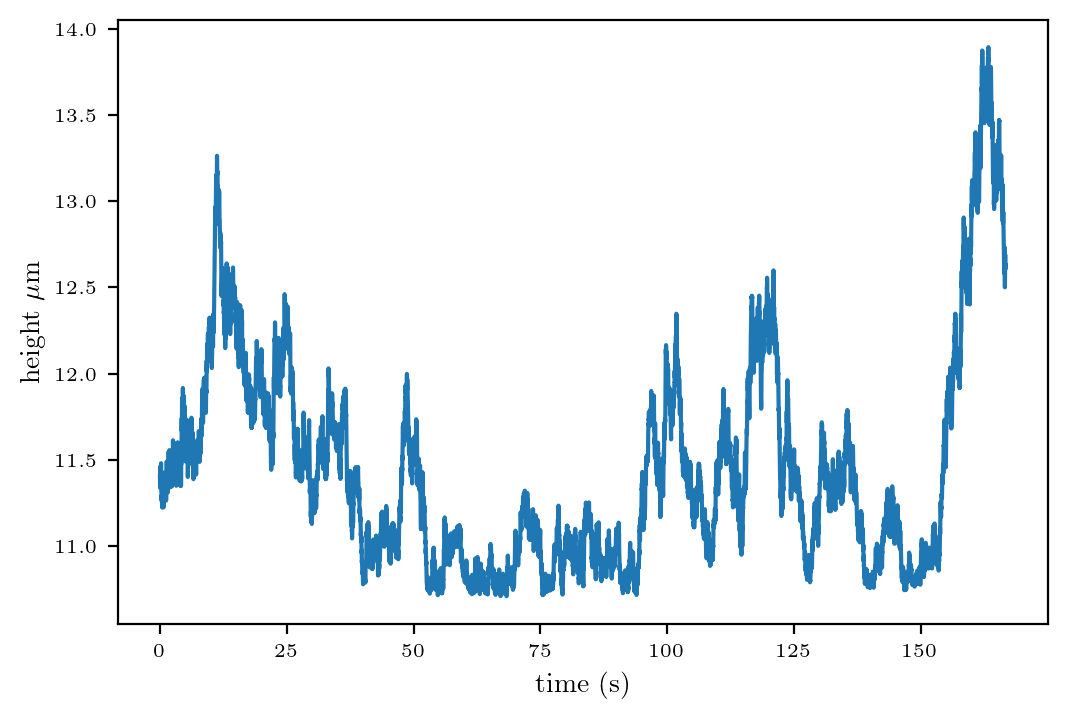

In [99]:
plt.plot(np.arange(len(z))/60, z)
plt.ylabel("height $\mathrm{\mu m}$")
plt.xlabel("time (s)")